In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/Othercomputers/Projects/MLops-with-GCP"

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [4]:
print(tf.__version__)

2.11.0


# Explore data

In [5]:
%cd "/content/drive/Othercomputers/Projects/MLops-with-GCP"

/content/drive/Othercomputers/Projects/MLops-with-GCP


In [6]:
!kaggle datasets download -d puneet6060/intel-image-classification --unzip

 97% 336M/346M [00:02<00:00, 176MB/s]
100% 346M/346M [00:02<00:00, 140MB/s]


In [7]:
import os
# Walk through pizza_steak directory and list number of files
print("Train data: ")
for dirpath, dirnames, filenames in os.walk("/content/drive/Othercomputers/Projects/MLops-with-GCP/seg_train/seg_train"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
print("Test data: ")
for dirpath, dirnames, filenames in os.walk("/content/drive/Othercomputers/Projects/MLops-with-GCP/seg_test/seg_test"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
print("Prediction data: ")
for dirpath, dirnames, filenames in os.walk("/content/drive/Othercomputers/Projects/MLops-with-GCP/seg_pred/seg_pred"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

Train data: 
There are 6 directories and 0 images in '/content/drive/Othercomputers/Projects/MLops-with-GCP/seg_train/seg_train'.
There are 0 directories and 2191 images in '/content/drive/Othercomputers/Projects/MLops-with-GCP/seg_train/seg_train/buildings'.
There are 0 directories and 2271 images in '/content/drive/Othercomputers/Projects/MLops-with-GCP/seg_train/seg_train/forest'.
There are 0 directories and 2404 images in '/content/drive/Othercomputers/Projects/MLops-with-GCP/seg_train/seg_train/glacier'.
There are 0 directories and 2512 images in '/content/drive/Othercomputers/Projects/MLops-with-GCP/seg_train/seg_train/mountain'.
There are 0 directories and 2274 images in '/content/drive/Othercomputers/Projects/MLops-with-GCP/seg_train/seg_train/sea'.
There are 0 directories and 2382 images in '/content/drive/Othercomputers/Projects/MLops-with-GCP/seg_train/seg_train/street'.
Test data: 
There are 6 directories and 0 images in '/content/drive/Othercomputers/Projects/MLops-with-GC

In [8]:
def view_random_image(target_dir, target_class):
    target_folder = os.path.join(target_dir, target_class)
    random_image = random.choice(os.listdir(target_folder))
    image_path = os.path.join(target_folder, random_image)
    img = mpimg.imread(image_path)

    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')
    print(f"Image shape: {img.shape}")

    return img

Image shape: (150, 150, 3)


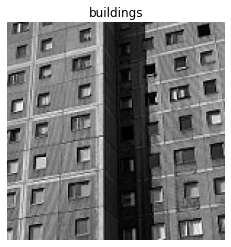

In [9]:
img = view_random_image(target_dir='/content/drive/Othercomputers/Projects/MLops-with-GCP/seg_train/seg_train',
                  target_class='buildings')

In [10]:
# Get the class name programmatically
import pathlib
data_dir = pathlib.Path("/content/drive/Othercomputers/Projects/MLops-with-GCP/seg_train/seg_train")
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


Image shape: (150, 150, 3)
Image shape: (150, 150, 3)
Image shape: (150, 150, 3)
Image shape: (150, 150, 3)
Image shape: (150, 150, 3)
Image shape: (150, 150, 3)
Image shape: (150, 150, 3)
Image shape: (150, 150, 3)
Image shape: (150, 150, 3)
Image shape: (150, 150, 3)
Image shape: (150, 150, 3)
Image shape: (150, 150, 3)
Image shape: (150, 150, 3)
Image shape: (150, 150, 3)
Image shape: (150, 150, 3)
Image shape: (150, 150, 3)
Image shape: (150, 150, 3)
Image shape: (150, 150, 3)


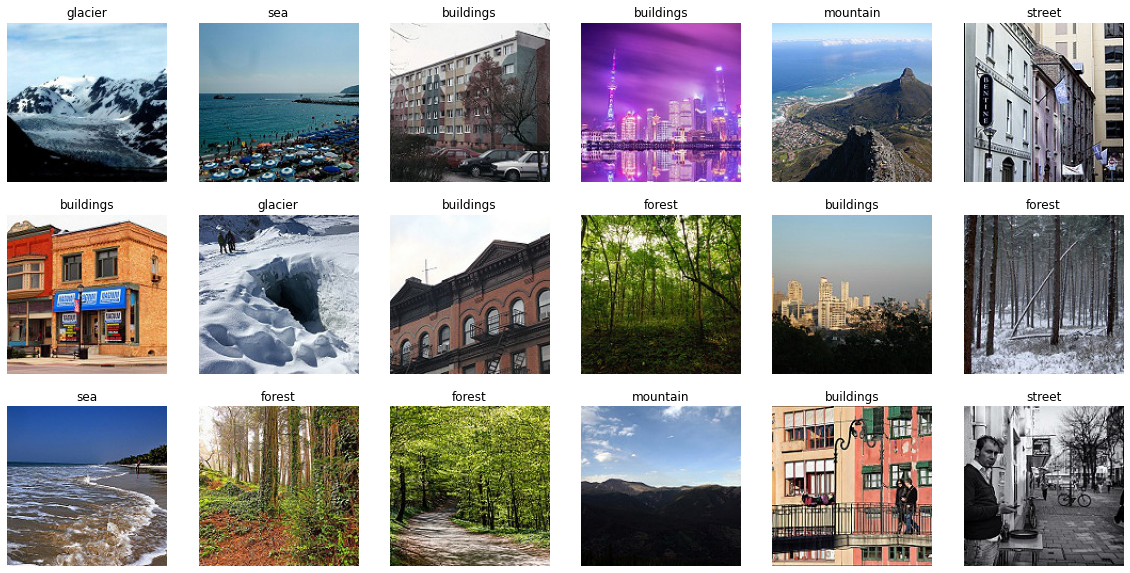

In [11]:
plt.figure(figsize=(20, 10))
for i in range(18):
  plt.subplot(3, 6, i+1)
  class_name = random.choice(class_names)
  img = view_random_image(target_dir='/content/drive/Othercomputers/Projects/MLops-with-GCP/seg_train/seg_train',
                  target_class=class_name)

# Prepare data for model

In [12]:
train_dir = "/content/drive/Othercomputers/Projects/MLops-with-GCP/seg_train/seg_train"
test_dir = "/content/drive/Othercomputers/Projects/MLops-with-GCP/seg_test/seg_test/"

In [13]:
# Create augmented data generator instance
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1/255.)

# Load data(data, label) from directory and turn them into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(150,150),
                                               batch_size=32,
                                               class_mode='categorical')
test_data = val_datagen.flow_from_directory(test_dir,
                                           target_size=(150,150),
                                           batch_size=32,
                                           class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# Basic model Buildinig (CNN Classifier)

In [14]:
model_1 = Sequential([
  Conv2D(16, 3, padding='same', activation='relu', input_shape=(150,150,3)),
  MaxPool2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(len(class_names), activation='softmax')
])

model_1.compile(loss="categorical_crossentropy",
              optimizer=Adam(),
              metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 64)       0

In [15]:
history_1 = model_1.fit(train_data,
                    epochs=4,
                    batch_size=32,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data))

Epoch 1/4
439/439 [==============================] - 131s 271ms/step - loss: 1.0349 - accuracy: 0.5926 - val_loss: 0.8987 - val_accuracy: 0.6703
Epoch 2/4
439/439 [==============================] - 111s 252ms/step - loss: 0.7767 - accuracy: 0.7136 - val_loss: 0.6601 - val_accuracy: 0.7630
Epoch 3/4
439/439 [==============================] - 109s 249ms/step - loss: 0.6625 - accuracy: 0.7526 - val_loss: 0.5902 - val_accuracy: 0.7883
Epoch 4/4
439/439 [==============================] - 110s 251ms/step - loss: 0.6052 - accuracy: 0.7800 - val_loss: 0.5654 - val_accuracy: 0.7973


In [16]:
model_1.evaluate(test_data)

94/94 [==============================] - 7s 79ms/step - loss: 0.5654 - accuracy: 0.7973


[0.5653876662254333, 0.7973333597183228]

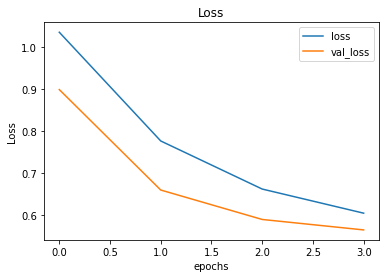

In [17]:
pd.DataFrame(history_1.history)[['loss','val_loss']].plot()
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss');

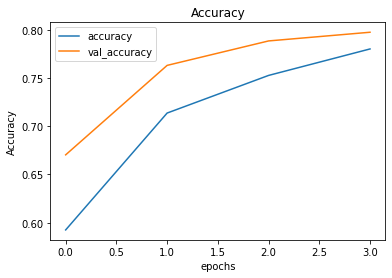

In [18]:
pd.DataFrame(history_1.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy');

In [21]:
model_1.save('/content/drive/Othercomputers/Projects/MLops-with-GCP/models/', save_format='tf')

In [22]:
!ls -alrt models

total 191
drwx------ 2 root root   4096 Feb 13 21:22 variables
-rw------- 1 root root 166351 Feb 13 21:22 saved_model.pb
-rw------- 1 root root  20230 Feb 13 21:22 keras_metadata.pb
-rw------- 1 root root     53 Feb 13 21:22 fingerprint.pb
drwx------ 2 root root   4096 Feb 13 21:22 assets


In [24]:
model_loaded = tf.keras.models.load_model('/content/drive/Othercomputers/Projects/MLops-with-GCP/models/')

In [25]:
model_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 64)       0

In [26]:
from PIL import Image
import numpy as np
from skimage import transform
def process(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')
   np_image = transform.resize(np_image, (150, 150, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

In [48]:
target_folder = "/content/drive/Othercomputers/Projects/MLops-with-GCP/seg_test/seg_test"
random_class = random.choice(os.listdir(target_folder))
random_image = random.choice(os.listdir(os.path.join(target_folder, random_class)))

print(f"true label is {random_class}")
pred_label=model_loaded.predict(process(os.path.join(target_folder, random_class,random_image)))
print(pred_label)
print(class_names[np.argmax(pred_label)])

true label is mountain
1/1 [==============================] - 0s 31ms/step
[[0.         0.         0.99761766 0.00238233 0.         0.        ]]
glacier


In [29]:
pred_label

array([[1., 0., 0., 0., 0., 0.]], dtype=float32)

In [30]:
!zip -r models.zip models/

  adding: models/ (stored 0%)
  adding: models/variables/ (stored 0%)
  adding: models/variables/variables.data-00000-of-00001 (deflated 23%)
  adding: models/variables/variables.index (deflated 63%)
  adding: models/assets/ (stored 0%)
  adding: models/fingerprint.pb (stored 0%)
  adding: models/saved_model.pb (deflated 89%)
  adding: models/keras_metadata.pb (deflated 91%)


In [39]:
target_folder = "/content/drive/Othercomputers/Projects/MLops-with-GCP/seg_test/seg_test"
random_class = random.choice(os.listdir(target_folder))
random_image = os.listdir(os.path.join(target_folder, random_class))
random_image

['20059.jpg',
 '20087.jpg',
 '20092.jpg',
 '20109.jpg',
 '20111.jpg',
 '20142.jpg',
 '20164.jpg',
 '20179.jpg',
 '20187.jpg',
 '20195.jpg',
 '20198.jpg',
 '20202.jpg',
 '20204.jpg',
 '20210.jpg',
 '20211.jpg',
 '20227.jpg',
 '20230.jpg',
 '20243.jpg',
 '20249.jpg',
 '20253.jpg',
 '20272.jpg',
 '20275.jpg',
 '20287.jpg',
 '20292.jpg',
 '20303.jpg',
 '20307.jpg',
 '20310.jpg',
 '20317.jpg',
 '20326.jpg',
 '20329.jpg',
 '20345.jpg',
 '20352.jpg',
 '20355.jpg',
 '20362.jpg',
 '20372.jpg',
 '20373.jpg',
 '20380.jpg',
 '20383.jpg',
 '20386.jpg',
 '20387.jpg',
 '20406.jpg',
 '20409.jpg',
 '20413.jpg',
 '20414.jpg',
 '20418.jpg',
 '20421.jpg',
 '20423.jpg',
 '20433.jpg',
 '20446.jpg',
 '20457.jpg',
 '20458.jpg',
 '20467.jpg',
 '20475.jpg',
 '20477.jpg',
 '20480.jpg',
 '20482.jpg',
 '20486.jpg',
 '20489.jpg',
 '20490.jpg',
 '20491.jpg',
 '20495.jpg',
 '20508.jpg',
 '20517.jpg',
 '20539.jpg',
 '20540.jpg',
 '20541.jpg',
 '20560.jpg',
 '20566.jpg',
 '20567.jpg',
 '20570.jpg',
 '20571.jpg',
 '2057